In [1]:
import time
from typing import Optional, Tuple, List


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              lr: float,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device, batch_size)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device:str, batch_size: int) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str, batch_size: int, lr: float) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                lr=lr,
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=batch_size,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class MyTransformer2d(nn.Module):
    def __init__(self, ch: int, kq_ch: int, img_size: int, ff_ch: int, kernel_size: int, extra_pad: int, num_heads: int):
        super(MyTransformer2d, self).__init__()

        self.kernel_size: int = kernel_size
        self.extra_pad: int = extra_pad

        # implementation but ineffective
        self.attention_heads = nn.ModuleList([MyAttention2d(in_ch=ch, kq_ch=kq_ch // num_heads, out_ch=ch, img_size=img_size, kernel_size=kernel_size, extra_pad=extra_pad) for _ in range(num_heads)])

        self.norm1 = nn.BatchNorm2d(ch)
        self.norm2 = nn.BatchNorm2d(ch)

        self.ff = nn.Sequential(
            nn.Conv2d(ch, ff_ch, kernel_size=1, bias=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ff_ch, ch, kernel_size=1, bias=True),
        )

    def forward(self, x):
        d_size = (self.kernel_size - 1) // 2 - self.extra_pad
        attended = torch.stack([head(x) for head in self.attention_heads], dim=4).sum(dim=4)
        x = self.norm1(attended + x[:, :, d_size:-d_size, d_size:-d_size])
        x = self.norm2(self.ff(x) + x)
        return x

In [7]:
class MyAttention2d(nn.Module):
    def __init__(self, in_ch: int, kq_ch: int, out_ch: int, img_size: int, kernel_size: int, extra_pad: int):
        super(MyAttention2d, self).__init__()

        self.in_ch: int = in_ch
        self.out_ch: int = out_ch
        self.img_size: int = img_size
        self.kernel_size: int = kernel_size
        self.extra_pad: int = extra_pad
        assert self.extra_pad >= 0

        # size = [b_s, ch, h, w]
        self.to_key = nn.Conv2d(in_ch, kq_ch, kernel_size=1, bias=False)
        self.to_query = nn.Conv2d(in_ch, kq_ch, kernel_size=1, bias=False)
        self.to_value = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)

        self.key_pos_embedding = nn.Parameter(torch.zeros(size=(1, 1, kq_ch)))
        self.query_pos_embedding = nn.Parameter(torch.zeros(size=(1, kernel_size ** 2, kq_ch)))
        self.value_pos_embedding = nn.Parameter(torch.zeros(size=(1, kernel_size ** 2, out_ch)))

        self.mask: nn.Parameter = nn.Parameter(self.make_mask(img_size, kernel_size, extra_pad))
        self.mask.requires_grad = False

    def make_mask(self, img_size: int, kernel_size: int, extra_pad: int):
        new_size = img_size + extra_pad * 2 - (kernel_size - 1)
        img_input = torch.zeros(1, 1, img_size, img_size)
        img_padded = F.pad(img_input, (extra_pad, extra_pad, extra_pad, extra_pad), mode="constant", value=-float("inf"))
        img_repacked = self.repack_img_valid_pad(img_padded)
        assert img_repacked.size() == (new_size * new_size, kernel_size ** 2, 1)
        img_repacked = torch.reshape(img_repacked, (1, new_size, new_size, kernel_size ** 2))
        return img_repacked

    def repack_img_valid_pad(self, img: torch.Tensor):
        batch_size, channels, height, width = img.size()
        assert width == self.img_size + self.extra_pad * 2
        assert height == self.img_size + self.extra_pad * 2

        img = img.view(batch_size, channels, height, width, 1)

        new_w = width - (self.kernel_size - 1)
        new_h = height - (self.kernel_size - 1)

        img = torch.cat([img[:, :, :, i: new_w + i] for i in range(self.kernel_size)], dim=4)
        img = torch.cat([img[:, :, i: new_h + i] for i in range(self.kernel_size)], dim=4)
        assert img.size() == (batch_size, channels, new_h, new_w, self.kernel_size ** 2)

        img = torch.moveaxis(img, 1, 4)
        assert img.size() == (batch_size, new_h, new_w, self.kernel_size ** 2, channels)

        img = img.reshape(batch_size * new_h * new_w, self.kernel_size ** 2, channels)
        return img

    def repack_keys(self, img: torch.Tensor):
        batch_size, channels, height, width = img.size()
        assert width == self.img_size + self.extra_pad * 2
        assert height == self.img_size + self.extra_pad * 2

        new_w = width - (self.kernel_size - 1)
        new_h = height - (self.kernel_size - 1)
        pad = (self.kernel_size - 1) // 2

        img = img[:, :, pad : new_h + pad, pad : new_w + pad]
        img = torch.moveaxis(img, 1, 3)
        assert img.size() == (batch_size, new_h, new_w, channels), f"expected {(batch_size, new_h, new_w, channels)}, got {img.size()}"

        img = img.reshape(batch_size * new_h * new_w, 1, channels)
        return img

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        new_height = height + self.extra_pad * 2 - (self.kernel_size - 1)
        new_width = width + self.extra_pad * 2 - (self.kernel_size - 1)

        if self.extra_pad != 0:
            p = self.extra_pad
            x = F.pad(x, (p, p, p, p), "constant", 0.0)

        key = self.to_key(x)
        query = self.to_query(x)
        value = self.to_value(x)

        packed_key = self.repack_keys(key) + self.key_pos_embedding
        # b, k**2, ch
        packed_query = self.repack_img_valid_pad(query) + self.query_pos_embedding
        # b, k**2, ch
        packed_value = self.repack_img_valid_pad(value) + self.value_pos_embedding
        # b, k**2, out_ch

        dots = torch.bmm(packed_key, torch.moveaxis(packed_query, 1, 2))
        assert dots.size() == (batch_size * new_height * new_width, 1, self.kernel_size ** 2)

        masked_dots = torch.reshape(dots, (batch_size, new_height, new_width, self.kernel_size ** 2))
        masked_dots = masked_dots + self.mask
        masked_dots = torch.reshape(masked_dots, (batch_size * new_height * new_width, 1, self.kernel_size ** 2))

        weights = F.softmax(masked_dots / 3.0, dim=2)
        # b, 1, k**2

        out = torch.bmm(weights, packed_value)
        assert out.size() == (batch_size * new_height * new_width, 1, self.out_ch)
        # b, 1, ch

        out = out.reshape(batch_size, new_height, new_width, self.out_ch)
        out = torch.moveaxis(out, 3, 1)

        assert out.size() == (batch_size, self.out_ch, new_height, new_width)
        return out


In [8]:
class MyConvT3(nn.Module):
    def __init__(self, channels: int, extra_pad: int, num_heads: int):
        super(MyConvT3, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=1, padding="valid", bias=False),  # 28
            MyTransformer2d(c, c, 28, c * 2, kernel_size=3 + 2 * extra_pad, extra_pad=extra_pad, num_heads=num_heads),  # 26
            MyTransformer2d(c, c, 26, c * 2, kernel_size=3 + 2 * extra_pad, extra_pad=extra_pad, num_heads=num_heads),  # 24
            nn.MaxPool2d(2),  # 12

            nn.Conv2d(c, c * 2, kernel_size=1, padding="valid", bias=False),  # 12
            MyTransformer2d(c * 2, c * 2, 12, c * 4, kernel_size=3 + 2 * extra_pad, extra_pad=extra_pad, num_heads=num_heads),  # 10
            MyTransformer2d(c * 2, c * 2, 10, c * 4, kernel_size=3 + 2 * extra_pad, extra_pad=extra_pad, num_heads=num_heads),  # 8
            nn.MaxPool2d(2),  # 4

            MyTransformer2d(c * 2, c * 4, 4, c * 8, kernel_size=3 + 2 * extra_pad, extra_pad=extra_pad, num_heads=num_heads),  # 2
            nn.Conv2d(c * 2, c * 4, kernel_size=2, padding="valid", bias=False),  # 1
            nn.BatchNorm2d(c * 4),
            nn.LeakyReLU(0.1),

            nn.Conv2d(c * 4, 10, kernel_size=1),  # 1
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)


In [9]:
model = MyConvT3(64, extra_pad=1, num_heads=4)
accuracies = []

In [10]:
TrainHelper.total_parameters_count(model)

1027834

In [11]:
batch_size = 32

In [12]:
accuracies += TrainHelper.train(
    lr = 0.0003,
    cnn=model,
    epochs=10,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=batch_size,
    device_name='cuda',
    print_results=True,
)

epoch 0, accuracy = 0.9813, loss = 0.011605696752667427
epoch 1, accuracy = 0.9849, loss = 0.2376014143228531
epoch 2, accuracy = 0.989, loss = 0.01146967988461256
epoch 3, accuracy = 0.9859, loss = 0.008069178089499474
epoch 4, accuracy = 0.9892, loss = 0.02337707206606865
epoch 5, accuracy = 0.9884, loss = 0.012124835513532162
epoch 6, accuracy = 0.9899, loss = 0.03446425125002861
epoch 7, accuracy = 0.9921, loss = 0.0020552624482661486
epoch 8, accuracy = 0.9915, loss = 0.003964578732848167
epoch 9, accuracy = 0.9922, loss = 9.616902389097959e-05


In [13]:
accuracies += TrainHelper.train(
    lr = 0.0001,
    cnn=model,
    epochs=10,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=batch_size,
    device_name='cuda',
    print_results=True,
)

epoch 0, accuracy = 0.9938, loss = 0.0009767914889380336
epoch 1, accuracy = 0.9937, loss = 6.424218008760363e-05
epoch 2, accuracy = 0.9945, loss = 0.0006581955822184682
epoch 3, accuracy = 0.9937, loss = 0.04351174831390381
epoch 4, accuracy = 0.994, loss = 2.7722242521122098e-05
epoch 5, accuracy = 0.9936, loss = 0.005530886352062225
epoch 6, accuracy = 0.9949, loss = 0.08377350866794586
epoch 7, accuracy = 0.9941, loss = 4.953483585268259e-05
epoch 8, accuracy = 0.9936, loss = 0.00014412656310014427
epoch 9, accuracy = 0.9945, loss = 4.032925426145084e-05


In [14]:
accuracies += TrainHelper.train(
    lr = 0.00001,
    cnn=model,
    epochs=10,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=batch_size,
    device_name='cuda',
    print_results=True,
)

epoch 0, accuracy = 0.9953, loss = 0.0001028548795147799
epoch 1, accuracy = 0.9955, loss = 6.172448775032535e-05
epoch 2, accuracy = 0.9957, loss = 1.4445834494836163e-05
epoch 3, accuracy = 0.9954, loss = 4.8892743507167324e-05
epoch 4, accuracy = 0.9955, loss = 0.001417443505488336
epoch 5, accuracy = 0.9953, loss = 0.00019716033420991153
epoch 6, accuracy = 0.9947, loss = 6.95190392434597e-05
epoch 7, accuracy = 0.9951, loss = 5.20309476996772e-05
epoch 8, accuracy = 0.9953, loss = 4.658003672375344e-05
epoch 9, accuracy = 0.9954, loss = 8.866503048921004e-05


In [15]:
accuracies += TrainHelper.train(
    lr = 0.000003,
    cnn=model,
    epochs=10,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=batch_size,
    device_name='cuda',
    print_results=True,
)

epoch 0, accuracy = 0.9954, loss = 3.889148047164781e-06
epoch 1, accuracy = 0.9953, loss = 1.0831831787072588e-05
epoch 2, accuracy = 0.9951, loss = 9.264326763513964e-06
epoch 3, accuracy = 0.9956, loss = 1.851180786616169e-05
epoch 4, accuracy = 0.9955, loss = 0.000297301885439083
epoch 5, accuracy = 0.9952, loss = 1.1986417121079285e-05
epoch 6, accuracy = 0.9953, loss = 9.525702625978738e-05
epoch 7, accuracy = 0.9954, loss = 0.0049956245347857475
epoch 8, accuracy = 0.9954, loss = 7.677727808186319e-06
epoch 9, accuracy = 0.9952, loss = 0.0008114860975183547


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


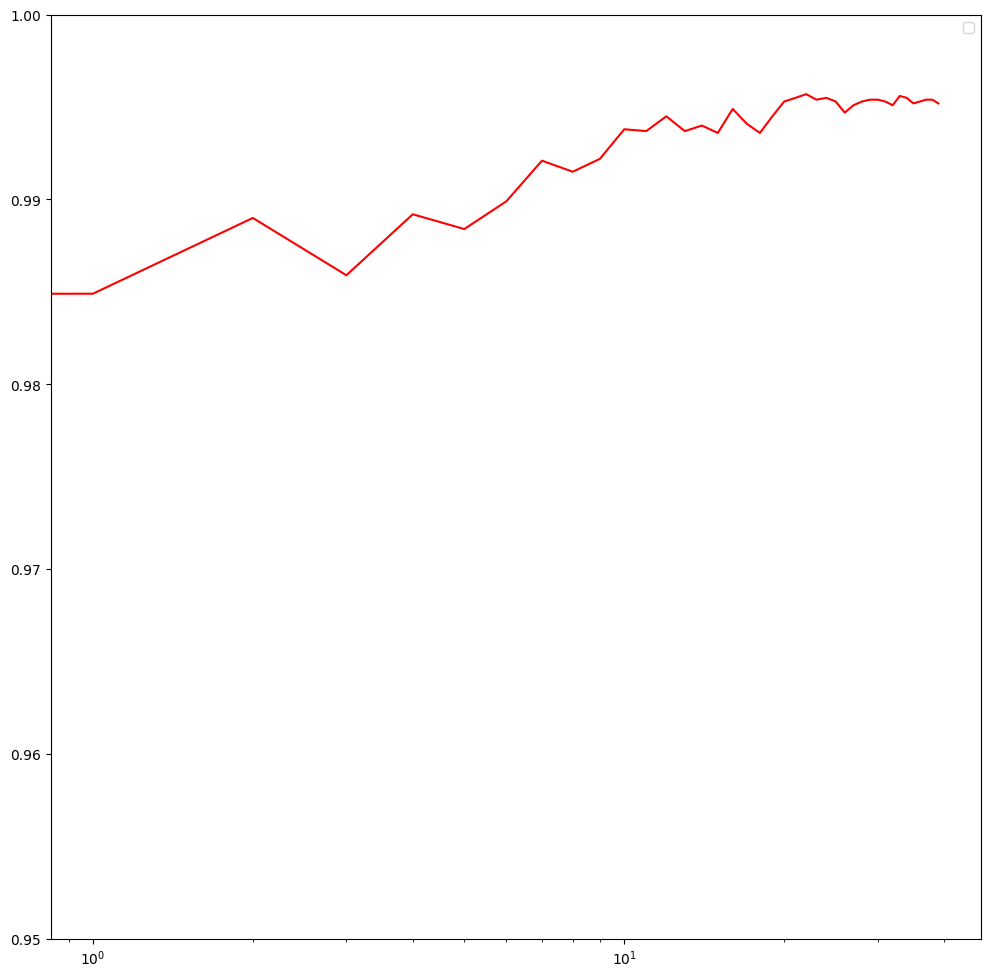

In [16]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.95, 1)

ax.plot(list(range(len(accuracies))), accuracies, c='red')
ax.legend()
plt.show()